In [1]:
# # Preparing the datasets


# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import cv2
# import os
# from PIL import Image, ImageDraw
# import random
# from sklearn.model_selection import train_test_split

# %matplotlib inline

# from colorama import Style, Fore
# blk = Style.BRIGHT + Fore.BLACK
# red = Style.BRIGHT + Fore.RED
# blu = Style.BRIGHT + Fore.BLUE
# res = Style.RESET_ALL

In [2]:
# # Defining directories
# base_dir = '/kaggle/input/footballplayer'
# annote_dir = f'{base_dir}/annotations/instances_default.json'
# images_dir = f'{base_dir}/images'

# # Output directories
# output_dir = '/kaggle/working/football_dataset'
# train_dir = f'{output_dir}/train/images'
# test_dir = f'{output_dir}/test/images'
# val_dir = f'{output_dir}/val/images'
# train_masks_dir = f'{output_dir}/train/masks'
# test_masks_dir = f'{output_dir}/test/masks'
# val_masks_dir = f'{output_dir}/val/masks'

# # making sure output directories exist
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)
# os.makedirs(train_masks_dir, exist_ok=True)
# os.makedirs(test_masks_dir, exist_ok=True)
# os.makedirs(val_masks_dir, exist_ok=True)

In [3]:
# with open(annote_dir, 'r') as f:
#     annotations = json.load(f)

# images = annotations['images']
# image_ids = [img['id'] for img in images]
# image_filenames = {img['id']: img['file_name'] for img in images}


In [4]:
# images_list = os.listdir(images_dir)
# train_images, temp_images = train_test_split(images_list, test_size=0.2, random_state=42)
# val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

In [5]:
# target_size = (512, 512)

# def create_mask(image_id, width, height, annotations):
#     mask = np.zeros((height, width), dtype=np.uint8)
#     for ann in annotations:
#         if ann['image_id'] == image_id:
#             segmentation = ann['segmentation'][0]
#             points = np.array(segmentation).reshape(-1, 2)
#             points = np.round(points).astype(np.int32)
#             cv2.fillPoly(mask, [points], color=255)
#     return mask

# annotations_list = annotations['annotations']

# for img_info in images:
#     img_id = img_info['id']
#     img_name = img_info['file_name']
#     width = img_info['width']
#     height = img_info['height']

#     mask = create_mask(img_id, width, height, annotations_list)
    
#     if img_name in train_images:
#         img_dest = os.path.join(train_dir, img_name)
#         mask_dest = os.path.join(train_masks_dir, img_name.replace('.jpg', '.png'))
#     elif img_name in val_images:
#         img_dest = os.path.join(val_dir, img_name)
#         mask_dest = os.path.join(val_masks_dir, img_name.replace('.jpg', '.png'))
#     elif img_name in test_images:
#         img_dest = os.path.join(test_dir, img_name)
#         mask_dest = os.path.join(test_masks_dir, img_name.replace('.jpg', '.png'))
#     else:
#         continue  # skipping if the image is not in any split

#     src_img_path = os.path.join(images_dir, img_name)
#     img = cv2.imread(src_img_path)
#     img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
#     cv2.imwrite(img_dest, img_resized)

#     mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    
#     cv2.imwrite(mask_dest, mask_resized)

# print(f"Images and masks resized to 512x512 and saved successfully.")

In [6]:
# !rm -rf /kaggle/working/*

In [7]:
# Unet Architecture

import torch
from torch import nn
import torchvision


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        self.Conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.Conv(x)


class Unet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(Unet, self).__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # down part

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # up part

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottomlayer = DoubleConv(features[-1], features[-1] * 2)

        self.finallayer = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):

        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottomlayer(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = torchvision.transforms.functional.resize(
                    x, size=skip_connection.shape[2:]
                )

            concat_skip = torch.cat((skip_connection, x), dim=1)

            x = self.ups[idx + 1](concat_skip)

        return self.finallayer(x)


In [8]:
# Datasets 

import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os


class FootballDatasets(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images=os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(
            self.mask_dir, self.images[index].replace(".jpg", ".png")
        )
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [9]:
from torch.utils.data import DataLoader


def save_checkpoint(state,filepath='/kaggle/working/checkpoint.pth.tar'):
    print("=> Saving checkpoint")
    torch.save(state,filepath)
    
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    
    
def get_loaders(
    train_img_dir,
    train_mask_dir,
    val_img_dir,
    val_mask_dir,
    test_img_dir,
    test_mask_dir,
    train_transforms,
    val_transforms,
    test_transforms,
    batch_size,
    num_of_workers,
    pin_memory,
):
    train_ds = FootballDatasets(image_dir=train_img_dir,mask_dir= train_mask_dir, transform=train_transforms)
    val_ds = FootballDatasets(image_dir=val_img_dir,mask_dir= val_mask_dir, transform=val_transforms)
    test_ds = FootballDatasets(image_dir=test_img_dir,mask_dir= test_mask_dir,transform= test_transforms)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_of_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_of_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        num_workers=num_of_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader, test_loader


def iou(outputs, labels) -> float:
    intersection = np.sum(np.logical_and(outputs, labels), axis=(1, 2, 3))
    union = np.sum(np.logical_or(outputs, labels), axis=(1, 2, 3))
    iou = intersection / union
    return np.mean(iou)

In [10]:
# directories for the datasets 

base_dir = '/kaggle/input/football-cleaned-dataset'
train_images = f'{base_dir}/train/images'
train_masks=f'{base_dir}/train/masks'

val_images = f'{base_dir}/val/images'
val_masks=f'{base_dir}/val/masks'

test_images = f'{base_dir}/test/images'
test_masks=f'{base_dir}/test/masks'

len(os.listdir(train_images)), len(os.listdir(train_masks))

(409, 409)

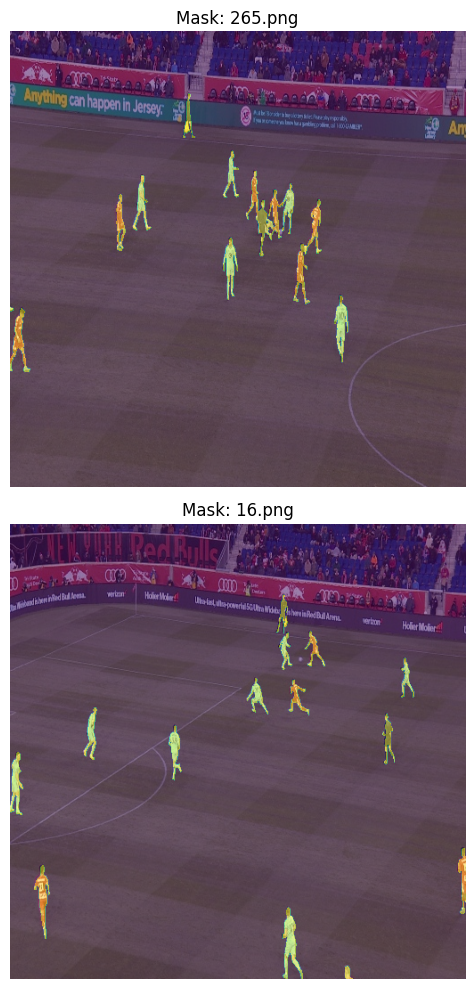

In [11]:
# visualization of data

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from PIL import Image

train_images_len = len(os.listdir(train_images))


plt.figure(figsize=(12, 10))  

rows = 2
columns = 2

torch.manual_seed(42)

random_indices = torch.randint(0, train_images_len, (rows,))
# print("Random indices:", random_indices)



for i, idx in enumerate(random_indices):
    
    image_filename = os.listdir(train_images)[idx.item()]
    
    img_path = os.path.join(train_images, image_filename)
    img = Image.open(img_path)
    
    img_size = img.size
#     print(f'Image: {image_filename} - Size: {img_size}')
    
    mask_filename = os.path.splitext(image_filename)[0] + '.png'
    
    
    mask_path = os.path.join(train_masks, mask_filename)
    mask = Image.open(mask_path)
    
    mask_size = mask.size
#     print(f'Mask: {mask_filename} - Size: {mask_size}')
    
   
    plt.subplot(rows, columns, i * 2 + 1)
    plt.imshow(img)
    plt.axis('off')  
    plt.title(f'Image: {image_filename}') 
    
   
    plt.subplot(rows, columns, i * 2 + 1)
    plt.imshow(mask, alpha=0.5) 
    plt.axis('off')  
    plt.title(f'Mask: {mask_filename}') 

plt.tight_layout() 
plt.show()

100%|██████████| 26/26 [00:42<00:00,  1.62s/it, loss=0.465]


Epoch 1/100, Training Loss: 0.5739005494576234, Validation Loss: 0.5483154654502869


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.379]


Epoch 2/100, Training Loss: 0.4134471554022569, Validation Loss: 0.4427369385957718


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.344]


Epoch 3/100, Training Loss: 0.3627897569766411, Validation Loss: 0.3478434905409813


100%|██████████| 26/26 [00:54<00:00,  2.11s/it, loss=0.311]


Epoch 4/100, Training Loss: 0.32451432255598217, Validation Loss: 0.31424298137426376


100%|██████████| 26/26 [00:54<00:00,  2.09s/it, loss=0.292]


Epoch 5/100, Training Loss: 0.3005233475795159, Validation Loss: 0.2947425991296768


100%|██████████| 26/26 [00:54<00:00,  2.09s/it, loss=0.274]


Epoch 6/100, Training Loss: 0.28208764585164875, Validation Loss: 0.2674771323800087


100%|██████████| 26/26 [00:54<00:00,  2.10s/it, loss=0.262]


Epoch 7/100, Training Loss: 0.267956765798422, Validation Loss: 0.2601862698793411


100%|██████████| 26/26 [00:54<00:00,  2.09s/it, loss=0.249]


Epoch 8/100, Training Loss: 0.2546719668003229, Validation Loss: 0.25031519681215286


100%|██████████| 26/26 [00:54<00:00,  2.09s/it, loss=0.238]


Epoch 9/100, Training Loss: 0.243052184008635, Validation Loss: 0.2369900494813919


100%|██████████| 26/26 [00:54<00:00,  2.09s/it, loss=0.227]


Epoch 10/100, Training Loss: 0.2320116666647104, Validation Loss: 0.22716167196631432


100%|██████████| 26/26 [00:54<00:00,  2.09s/it, loss=0.219]


Epoch 11/100, Training Loss: 0.22213775721880105, Validation Loss: 0.22111788392066956


100%|██████████| 26/26 [00:54<00:00,  2.09s/it, loss=0.209]


Epoch 12/100, Training Loss: 0.21330939061366594, Validation Loss: 0.21129140257835388


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.2]


Epoch 13/100, Training Loss: 0.2038997824375446, Validation Loss: 0.20426396280527115


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.191]


Epoch 14/100, Training Loss: 0.1950740539110624, Validation Loss: 0.1951339840888977


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.183]


Epoch 15/100, Training Loss: 0.186687368613023, Validation Loss: 0.18091919273138046


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.176]


Epoch 16/100, Training Loss: 0.17915560133182085, Validation Loss: 0.1763138324022293


100%|██████████| 26/26 [00:54<00:00,  2.09s/it, loss=0.168]


Epoch 17/100, Training Loss: 0.17171300718417534, Validation Loss: 0.17234231531620026


100%|██████████| 26/26 [00:54<00:00,  2.09s/it, loss=0.162]


Epoch 18/100, Training Loss: 0.16487356160695738, Validation Loss: 0.16567939892411232


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.155]


Epoch 19/100, Training Loss: 0.15830531659034583, Validation Loss: 0.1599438413977623


100%|██████████| 26/26 [00:54<00:00,  2.09s/it, loss=0.149]


Epoch 20/100, Training Loss: 0.15207635840544334, Validation Loss: 0.14855089038610458


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.143]


Epoch 21/100, Training Loss: 0.14608575919499764, Validation Loss: 0.14458412304520607


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.138]


Epoch 22/100, Training Loss: 0.14050640566990927, Validation Loss: 0.13895155861973763


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.133]


Epoch 23/100, Training Loss: 0.13503369230490464, Validation Loss: 0.1308092251420021


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.128]


Epoch 24/100, Training Loss: 0.13008817571860093, Validation Loss: 0.13031264021992683


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.123]


Epoch 25/100, Training Loss: 0.1251603112770961, Validation Loss: 0.12498125061392784


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.118]


Epoch 26/100, Training Loss: 0.12065382960897225, Validation Loss: 0.11893009394407272


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.114]


Epoch 27/100, Training Loss: 0.1161568073125986, Validation Loss: 0.1149062979966402


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.11]


Epoch 28/100, Training Loss: 0.11215044070894901, Validation Loss: 0.11156361736357212


100%|██████████| 26/26 [00:53<00:00,  2.08s/it, loss=0.106]


Epoch 29/100, Training Loss: 0.10813826437179859, Validation Loss: 0.10857971757650375


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.103]


Epoch 30/100, Training Loss: 0.10439501731441571, Validation Loss: 0.1032149288803339


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0985]


Epoch 31/100, Training Loss: 0.1007828082029636, Validation Loss: 0.10139804147183895


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0955]


Epoch 32/100, Training Loss: 0.09743168434271446, Validation Loss: 0.09545337222516537


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.0932]


Epoch 33/100, Training Loss: 0.09425172811517349, Validation Loss: 0.09272590093314648


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.0903]


Epoch 34/100, Training Loss: 0.09116580251317757, Validation Loss: 0.08959304727613926


100%|██████████| 26/26 [00:53<00:00,  2.08s/it, loss=0.0876]


Epoch 35/100, Training Loss: 0.08823583045831093, Validation Loss: 0.08774635195732117


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.0863]


Epoch 36/100, Training Loss: 0.08536489737721589, Validation Loss: 0.08381893299520016


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.08]


Epoch 37/100, Training Loss: 0.08264934701415208, Validation Loss: 0.08152312971651554


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.0789]


Epoch 38/100, Training Loss: 0.08021569939760062, Validation Loss: 0.07862396351993084


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0812]


Epoch 39/100, Training Loss: 0.07771850835818511, Validation Loss: 0.07761172950267792


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.0738]


Epoch 40/100, Training Loss: 0.07586133652008496, Validation Loss: 0.07504928670823574


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.0712]


Epoch 41/100, Training Loss: 0.07323427154467656, Validation Loss: 0.07235810160636902


100%|██████████| 26/26 [00:53<00:00,  2.08s/it, loss=0.0696]


Epoch 42/100, Training Loss: 0.07106394664599346, Validation Loss: 0.07014591246843338


100%|██████████| 26/26 [00:53<00:00,  2.08s/it, loss=0.0677]


Epoch 43/100, Training Loss: 0.06889522820711136, Validation Loss: 0.06883757188916206


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0655]


Epoch 44/100, Training Loss: 0.06703724167667903, Validation Loss: 0.06624993123114109


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0646]


Epoch 45/100, Training Loss: 0.06510056182742119, Validation Loss: 0.06528767943382263


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0613]


Epoch 46/100, Training Loss: 0.06340414342971948, Validation Loss: 0.06259637977927923


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.061]


Epoch 47/100, Training Loss: 0.06162500080580895, Validation Loss: 0.05975200515240431


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0591]


Epoch 48/100, Training Loss: 0.059877193747804716, Validation Loss: 0.058255378156900406


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.057]


Epoch 49/100, Training Loss: 0.05829744700055856, Validation Loss: 0.05731204617768526


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0559]


Epoch 50/100, Training Loss: 0.0569285681614509, Validation Loss: 0.056398662738502026


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0556]


Epoch 51/100, Training Loss: 0.05538679057588944, Validation Loss: 0.05461557023227215


100%|██████████| 26/26 [00:53<00:00,  2.06s/it, loss=0.0532]


Epoch 52/100, Training Loss: 0.05405597603664948, Validation Loss: 0.05230364017188549


100%|██████████| 26/26 [00:53<00:00,  2.06s/it, loss=0.0511]


Epoch 53/100, Training Loss: 0.05243128581115833, Validation Loss: 0.05146474298089743


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0512]


Epoch 54/100, Training Loss: 0.051301113258187585, Validation Loss: 0.04986264184117317


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.05]


Epoch 55/100, Training Loss: 0.05001942655788018, Validation Loss: 0.04868420213460922


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0481]


Epoch 56/100, Training Loss: 0.048905556878218286, Validation Loss: 0.048752669245004654


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0468]


Epoch 57/100, Training Loss: 0.04770084642446958, Validation Loss: 0.04657025169581175


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0471]


Epoch 58/100, Training Loss: 0.046619949862360954, Validation Loss: 0.04496022965759039


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0455]


Epoch 59/100, Training Loss: 0.04559052549302578, Validation Loss: 0.043748388066887856


100%|██████████| 26/26 [00:53<00:00,  2.06s/it, loss=0.0442]


Epoch 60/100, Training Loss: 0.04475501666848476, Validation Loss: 0.04319017939269543


100%|██████████| 26/26 [00:53<00:00,  2.06s/it, loss=0.0431]


Epoch 61/100, Training Loss: 0.043612898828891605, Validation Loss: 0.041132052429020405


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0434]


Epoch 62/100, Training Loss: 0.04259917655816445, Validation Loss: 0.04173400346189737


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0401]


Epoch 63/100, Training Loss: 0.04175124904857232, Validation Loss: 0.039636838249862194


100%|██████████| 26/26 [00:53<00:00,  2.08s/it, loss=0.0417]


Epoch 64/100, Training Loss: 0.040862901852681086, Validation Loss: 0.03993197996169329


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0393]


Epoch 65/100, Training Loss: 0.03992206058823145, Validation Loss: 0.038051811046898365


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0391]


Epoch 66/100, Training Loss: 0.039022351400210306, Validation Loss: 0.0375367347151041


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0372]


Epoch 67/100, Training Loss: 0.03818726023802391, Validation Loss: 0.037905155681073666


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0366]


Epoch 68/100, Training Loss: 0.03755750593084555, Validation Loss: 0.03559701889753342


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0373]


Epoch 69/100, Training Loss: 0.036889114058934726, Validation Loss: 0.03682080563157797


100%|██████████| 26/26 [00:53<00:00,  2.06s/it, loss=0.0356]


Epoch 70/100, Training Loss: 0.03593608865944239, Validation Loss: 0.03446021396666765


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0349]


Epoch 71/100, Training Loss: 0.0355250950043018, Validation Loss: 0.03337037190794945


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0357]


Epoch 72/100, Training Loss: 0.03491354633409243, Validation Loss: 0.034543885849416256


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0338]


Epoch 73/100, Training Loss: 0.03408279212621542, Validation Loss: 0.03221000172197819


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0325]


Epoch 74/100, Training Loss: 0.03340779345196027, Validation Loss: 0.03281517792493105


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0315]


Epoch 75/100, Training Loss: 0.03270126965183478, Validation Loss: 0.03165440307930112


100%|██████████| 26/26 [00:53<00:00,  2.06s/it, loss=0.0314]


Epoch 76/100, Training Loss: 0.03212356474250555, Validation Loss: 0.03075556643307209


100%|██████████| 26/26 [00:53<00:00,  2.08s/it, loss=0.0316]


Epoch 77/100, Training Loss: 0.03169568183903511, Validation Loss: 0.030463766306638718


100%|██████████| 26/26 [00:53<00:00,  2.08s/it, loss=0.031]


Epoch 78/100, Training Loss: 0.031110513812074296, Validation Loss: 0.029616078827530146


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0306]


Epoch 79/100, Training Loss: 0.030659490838073768, Validation Loss: 0.028922895900905132


100%|██████████| 26/26 [00:53<00:00,  2.08s/it, loss=0.0298]


Epoch 80/100, Training Loss: 0.03022133709432987, Validation Loss: 0.028465684037655592


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.0299]


Epoch 81/100, Training Loss: 0.029570913801972683, Validation Loss: 0.028228677343577147


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.0287]


Epoch 82/100, Training Loss: 0.029081963289242525, Validation Loss: 0.027989933732897043


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0277]


Epoch 83/100, Training Loss: 0.028575651849118564, Validation Loss: 0.026703049894422293


100%|██████████| 26/26 [00:53<00:00,  2.06s/it, loss=0.0286]


Epoch 84/100, Training Loss: 0.028175636266286556, Validation Loss: 0.02667112834751606


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0274]


Epoch 85/100, Training Loss: 0.027672084191670783, Validation Loss: 0.026204912923276424


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.0286]


Epoch 86/100, Training Loss: 0.02732931715078079, Validation Loss: 0.025412380695343018


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.0279]


Epoch 87/100, Training Loss: 0.02710193882767971, Validation Loss: 0.025281977839767933


100%|██████████| 26/26 [00:53<00:00,  2.08s/it, loss=0.0266]


Epoch 88/100, Training Loss: 0.02659809309989214, Validation Loss: 0.025321241933852434


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.0258]


Epoch 89/100, Training Loss: 0.026215309850298442, Validation Loss: 0.025803199503570795


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.0262]


Epoch 90/100, Training Loss: 0.02579147397325589, Validation Loss: 0.023868990130722523


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0247]


Epoch 91/100, Training Loss: 0.025392265775455877, Validation Loss: 0.024623283185064793


100%|██████████| 26/26 [00:53<00:00,  2.08s/it, loss=0.0253]


Epoch 92/100, Training Loss: 0.025006436814482395, Validation Loss: 0.023450064472854137


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0246]


Epoch 93/100, Training Loss: 0.024613653094722673, Validation Loss: 0.023502084892243147


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.024]


Epoch 94/100, Training Loss: 0.024284019994621094, Validation Loss: 0.023910798598080873


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.0239]


Epoch 95/100, Training Loss: 0.02390532396160639, Validation Loss: 0.022544532548636198


100%|██████████| 26/26 [00:53<00:00,  2.07s/it, loss=0.0243]


Epoch 96/100, Training Loss: 0.023523862831867658, Validation Loss: 0.02198463724926114


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.0236]


Epoch 97/100, Training Loss: 0.023225023267933957, Validation Loss: 0.022148424293845892


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.0227]


Epoch 98/100, Training Loss: 0.022909030891381778, Validation Loss: 0.021796144545078278


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.0227]


Epoch 99/100, Training Loss: 0.02257264921298394, Validation Loss: 0.02053447999060154


100%|██████████| 26/26 [00:54<00:00,  2.08s/it, loss=0.0216]


Epoch 100/100, Training Loss: 0.022264078116187684, Validation Loss: 0.020772781688719988


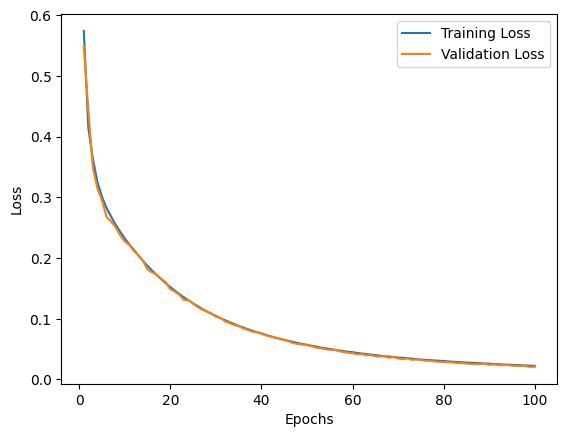

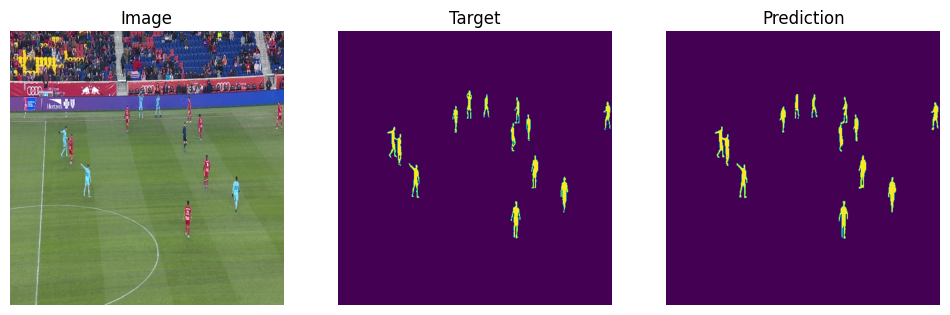

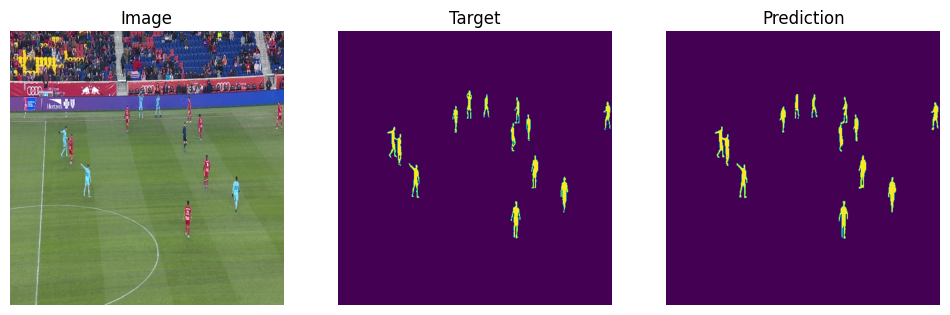

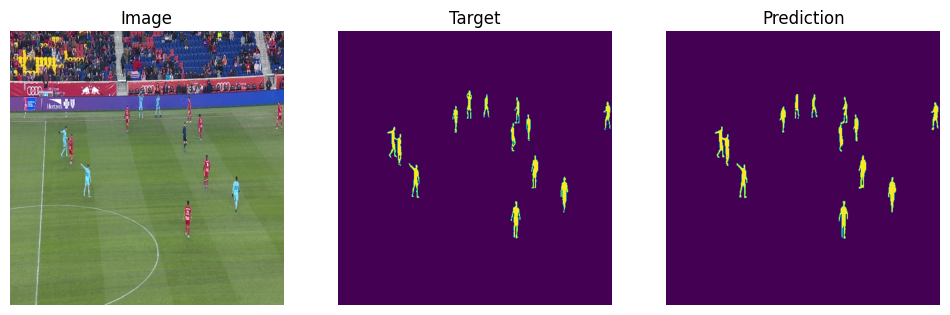

Model and optimizer states saved to /kaggle/working/unet_model.pth


In [12]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Hyperparameters
img_width = 512
img_height = 512
epochs = 100
lr = 1e-4
batch_size = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_of_workers = 2
pin_memory = True

# Train function
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    losses = []
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.float().unsqueeze(1).to(device=device)

        with torch.amp.autocast(device):
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            losses.append(loss.item())

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # updating the tqdm
        loop.set_postfix(loss=loss.item())

    return sum(losses) / len(losses)

# Validation function
def eval_fn(loader, model, loss_fn):
    model.eval()
    losses = []
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(loader):
            data = data.to(device=device)
            targets = targets.float().unsqueeze(1).to(device=device)

            predictions = model(data)
            loss = loss_fn(predictions, targets)
            losses.append(loss.item())

    model.train()
    return sum(losses) / len(losses)

# Main function
def main():
    train_transform = A.Compose(
        [
            A.Resize(height=img_height, width=img_width),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )
    test_val_transforms = A.Compose(
        [
            A.Resize(height=img_height, width=img_width),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    model = Unet(in_channels=3, out_channels=1).to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loader, val_loader, test_loader = get_loaders(
        train_img_dir=train_images,
        train_mask_dir=train_masks,
        val_img_dir=val_images,
        val_mask_dir=val_masks,
        test_img_dir=test_images,
        test_mask_dir=test_masks,
        train_transforms=train_transform,
        val_transforms=test_val_transforms,
        test_transforms=test_val_transforms,
        batch_size=batch_size,
        num_of_workers=num_of_workers,
        pin_memory=pin_memory
    )

    scaler = torch.amp.GradScaler()

    epoch_count = []
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = train_fn(loader=train_loader, model=model, loss_fn=loss_fn, optimizer=optimizer, scaler=scaler)
        val_loss = eval_fn(loader=val_loader, model=model, loss_fn=loss_fn)

        epoch_count.append(epoch + 1)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}")

    # Plotting the learning curve
    plt.plot(epoch_count, train_losses, label='Training Loss')
    plt.plot(epoch_count, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluation on test data
    model.eval()
    with torch.no_grad():
        for i in range(3):
            data, targets = next(iter(test_loader))
            data = data.to(device=device)
            targets = targets.to(device=device)

            predictions = torch.sigmoid(model(data))
            predictions = (predictions > 0.5).float()

            plt.figure(figsize=(12, 8))
            plt.subplot(1, 3, 1)
            plt.imshow(data[0].permute(1, 2, 0).cpu())
            plt.title("Image")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(targets[0].squeeze().cpu())
            plt.title("Target")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[0].squeeze().cpu())
            plt.title("Prediction")
            plt.axis('off')

            plt.show()
        # Save the model and optimizer states
        model_save_path = '/kaggle/working/unet_model.pth'
        torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': val_loss,
        }, model_save_path)

        print(f'Model and optimizer states saved to {model_save_path}')

main()


In [13]:
# import requests
# from pathlib import Path

# # Define the URL of the image
# url = 'https://images.hindustantimes.com/rf/image_size_630x354/HT/p2/2020/02/14/Pictures/football-match-in-bhubaneswar_294d406a-4f4e-11ea-be2e-10ce700f7947.jpg'

# # Define the path where you want to save the image
# save_path = Path('football_match.jpg')  # You can name the file as you like

# # Send a GET request to the URL
# response = requests.get(url)

# # Check if the request was successful
# if response.status_code == 200:
#     # Write the content to the file
#     with open(save_path, 'wb') as f:
#         f.write(response.content)
#     print(f"Image successfully downloaded: {save_path}")
# else:
#     print("Failed to download the image.")


In [14]:
# # Reconstruct the model
# model = Unet(in_channels=3, out_channels=1).to(device)

# # Load the saved model state
# checkpoint = torch.load('/kaggle/working/unet_model.pth', map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])

# # If you need to load the optimizer as well
# optimizer = optim.Adam(model.parameters(), lr=lr)  # Ensure to use the same learning rate
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# # Set the model to evaluation mode
# model.eval()

In [15]:
# from PIL import Image
# import numpy as np

# sample_image_path = '/kaggle/working/football_match.jpg' 
# image = Image.open(sample_image_path).convert("RGB")
# image = np.array(image)

# transform = A.Compose([
#     A.Resize(height=img_height, width=img_width),
#     A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
#     ToTensorV2(),
# ])

# sample_image = transform(image=image)["image"].unsqueeze(0).to(device)


In [16]:
with torch.no_grad():
    prediction = model(sample_image)
    prediction = torch.sigmoid(prediction)
    prediction = (prediction > 0.5).float()  
    
predicted_mask = prediction.squeeze().cpu().numpy()


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()


NameError: name 'model' is not defined

In [ ]:
# import shutil

# output_dir = '/kaggle/working/football_dataset'

# zip_file = '/kaggle/working/football_dataset.zip'

# shutil.make_archive(base_name=zip_file.replace('.zip', ''), format='zip', root_dir=output_dir)

# print(f"Output directory compressed into {zip_file}")
